<a href="https://colab.research.google.com/github/josuebatista/PyTorchOCR/blob/main/PyTorch_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optical Character Recognition Using PyTorch

This project provides an implementation of an Optical Character Recognition (OCR) model using PyTorch. We train a Convolutional Neural Network (CNN) to recognize individual characters in natural images.

In [37]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)

#To manage whether there is a google drive connected or not
drive_mounted = False

In [38]:
from google.colab import drive
try:
    drive.mount('/content/drive', force_remount=True)
    drive_mounted = True
except:
    drive_mounted = False

if drive_mounted:
    print("Google Drive is connected.")
else:
    print("Google Drive is not connected.")


Mounted at /content/drive
Google Drive is connected.


## Dataset

We make use of the [Chars74K dataset](http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/), which provides images of individual characters, including variations in scale, and maintaining the original resolution of the characters as they appear in the original images.

Specifically, we are using the `EnglishFnt.tgz` file, which contains characters from computer fonts with 4 variations (combinations of italic, bold, and normal). This dataset has 62 classes, consisting of digits 0-9, uppercase letters A-Z, and lowercase letters a-z.


In [5]:
'''
The Chars74K dataset
Character Recognition in Natural Images
http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/
Images of individual characters: the files below contain directory trees of each dataset of individual characters. In these trees, there is one directory per class of character. Each character sample appear in an individual PNG image. There's a large variation is scale, as we kept the original resolution of the characters as they appear in the original images.
English, 62 classes (0-9, A-Z, a-z)
EnglishFnt.tgz (51.1 MB): characters from computer fonts with 4 variations (combinations of italic, bold and normal).
'''

import tarfile

if drive_mounted:
    tar = tarfile.open('/content/drive/MyDrive/Python_OCR/EnglishFnt.tgz')
else:
    !wget -O EnglishFnt.tgz http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishFnt.tgz
    tar = tarfile.open('EnglishFnt.tgz')

tar.extractall('./EnglishFnt')
tar.close()

--2023-06-14 13:24:16--  http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishFnt.tgz
Resolving www.ee.surrey.ac.uk (www.ee.surrey.ac.uk)... 131.227.80.48
Connecting to www.ee.surrey.ac.uk (www.ee.surrey.ac.uk)|131.227.80.48|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49817950 (48M) [application/x-gzip]
Saving to: ‘EnglishFnt.tgz’

EnglishFnt.tgz      100%[===================>]  47.51M  14.6MB/s    in 3.3s    

2023-06-14 13:24:20 (14.6 MB/s) - ‘EnglishFnt.tgz’ saved [49817950/49817950]



## Task 1: Image Preprocessing

The images are preprocessed before feeding them into the model. The preprocessing steps include resizing the images, randomly flipping the images horizontally for data augmentation, converting the images into PyTorch tensors, and normalizing the pixel values.


In [40]:
data = torchvision.datasets.ImageFolder(
    root='./EnglishFnt/English/Fnt',
    transform=transforms.Compose([
        transforms.Resize((48, 48)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
)

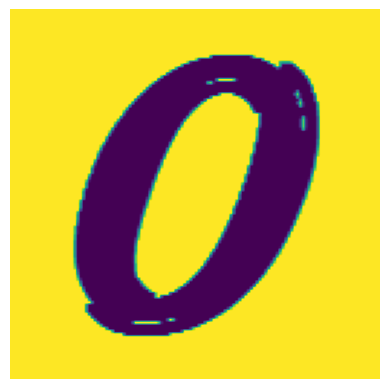

torch.Size([1, 1, 48, 48])


In [41]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Load and display the image
image_path = '/content/EnglishFnt/English/Fnt/Sample001/img001-00012.png'  # Replace with the path to your actual image
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

# Preprocess the image
preprocess = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
preprocessed_image = preprocess(image)

# Add a batch dimension
input_tensor = preprocessed_image.unsqueeze(0)

# Verify the shape of the input tensor
print(input_tensor.shape)

## Task 2: Data Loading and Preparation

We load the dataset and prepare it by splitting into training, validation, and testing sets.

In [42]:
def load_split(dataset, batch_size, test_split=0.3, random_seed=42):
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    np.random.seed(random_seed)
    np.random.shuffle(indices)

    split = int(np.floor(test_split * dataset_size))
    train_indices, test_indices = indices[split:], indices[:split]

    testset_size = len(test_indices)
    indices = list(range(testset_size))
    np.random.seed(random_seed)
    np.random.shuffle(indices)

    split = int(np.floor(0.5 * testset_size))
    val_indices, test_indices = indices[split:], indices[:split]

    # Creating data samplers:
    train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
    test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

    # Creating data loaders:
    train_loader = torch.utils.data.DataLoader(dataset, batch_size, sampler=train_sampler)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size, sampler=test_sampler)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size, sampler=val_sampler)

    return train_loader, test_loader, val_loader

In [43]:
batch_size = 36
train_loader, test_loader, val_loader = load_split(data, batch_size, test_split=0.3)

In [44]:
for batch in train_loader:
    images, labels = batch
    print(images.shape)  # Print the shape of the batch of images
    print(labels.shape)  # Print the shape of the batch of labels
    break  # Print only the first batch

torch.Size([36, 3, 48, 48])
torch.Size([36])


## Task 3: Building a CNN and One-hot-encoding

We then define a simple Convolutional Neural Network (CNN) architecture for the OCR model. The output size of the fully connected layer is set to 62, corresponding to the 62 classes in our dataset.

In [45]:
class OCRNet(nn.Module):
    def __init__(self, num_features):
        super(OCRNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(num_features, 62)  # Output has 62 classes instead of 10

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

num_features = 32 * 48 * 48  # Adjust this value based on the actual feature size
model = OCRNet(num_features)

## Task 4: Set the Optimizer and Loss Functions

Stochastic Gradient Descent (SGD) is used as the optimizer, and Cross Entropy Loss is used as the loss function.

In [46]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

## Task 5: Training the Model

The model is trained using the training set. The loss for each epoch is printed to monitor the training process.

In [ ]:
def train(model, train_loader, optimizer, criterion, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

In [47]:
def train(model, train_loader, optimizer, criterion, num_epochs=10, print_every=100):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_count = 0
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_count += 1

            # Print average loss every 'print_every' mini-batches
            if (i+1) % print_every == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Average Loss: {running_loss/running_count:.4f}")
                running_loss = 0.0
                running_count = 0

        # Print loss after each epoch
        epoch_loss = running_loss / len(train_loader)
        print(f"\nEnd of Epoch {epoch+1}/{num_epochs}, Average Epoch Loss: {epoch_loss:.4f}")


In [48]:
# Call the training function
train(model, train_loader, optimizer, criterion, num_epochs=20)

Epoch [1/20], Step [100/1225], Average Loss: 3.4896
Epoch [1/20], Step [200/1225], Average Loss: 2.0695
Epoch [1/20], Step [300/1225], Average Loss: 1.7340
Epoch [1/20], Step [400/1225], Average Loss: 1.6517
Epoch [1/20], Step [500/1225], Average Loss: 1.4815
Epoch [1/20], Step [600/1225], Average Loss: 1.3765
Epoch [1/20], Step [700/1225], Average Loss: 1.3546
Epoch [1/20], Step [800/1225], Average Loss: 1.2338
Epoch [1/20], Step [900/1225], Average Loss: 1.2180
Epoch [1/20], Step [1000/1225], Average Loss: 1.2224
Epoch [1/20], Step [1100/1225], Average Loss: 1.2404
Epoch [1/20], Step [1200/1225], Average Loss: 1.1336

End of Epoch 1/20, Average Epoch Loss: 0.0214
Epoch [2/20], Step [100/1225], Average Loss: 1.0316
Epoch [2/20], Step [200/1225], Average Loss: 1.0621
Epoch [2/20], Step [300/1225], Average Loss: 1.0243
Epoch [2/20], Step [400/1225], Average Loss: 1.0468
Epoch [2/20], Step [500/1225], Average Loss: 0.9753
Epoch [2/20], Step [600/1225], Average Loss: 0.9836
Epoch [2/20], 

## Task 6: Validate the Model

After training, we validate the model using the validation set.

In [49]:
def validate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = running_loss / len(val_loader)
    accuracy = 100 * correct / total
    print(f'Validation Loss: {avg_loss:.4f}, Validation Accuracy: {accuracy:.2f}%')

validate(model, val_loader, criterion)

Validation Loss: 0.1820, Validation Accuracy: 94.55%


## Task 7: Testing the Model

Finally, the model is tested using the test set.

In [50]:
def test(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = running_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

test(model, test_loader, criterion)

Test Loss: 0.1939, Test Accuracy: 94.51%


## Task 8: Saving and Loading the Model

We can save the trained model for later use or further training. To load the model, we first initialize an instance of the model and then load the parameters.

In [52]:
# Save model
if drive_mounted:
    torch.save(model.state_dict(), '/content/drive/MyDrive/Python_OCR/PyTorch_OCR_20230614a.pth')
else:
    torch.save(model.state_dict(), '/content/PyTorch_OCR.pth')

In [15]:
# Load model
model = OCRNet(num_features)
if drive_mounted:
    model.load_state_dict(torch.load('/content/drive/MyDrive/Python_OCR/PyTorch_OCR_20230613a.pth'))
else:
    model.load_state_dict(torch.load('/content/drive/MyDrive/Python_OCR/PyTorch_OCR.pth'))
model.eval()  # Ensure the model is in evaluation mode

OCRNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=73728, out_features=62, bias=True)
)

## Task 9: Making Predictions

The trained model can be used to predict the class of a single image.

Predicted Class: A, Confidence: 96.65%


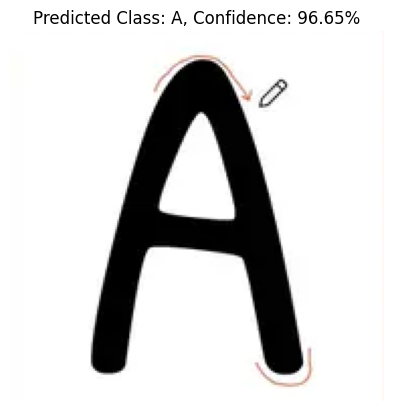

In [76]:
import torch.nn.functional as F

classes = list('0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz')

def predict(model, image_path, transform):
    image = Image.open(image_path).convert('RGB')  # Convert to RGB
    image = transform(image).unsqueeze(0)

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        output = model(image)
        probabilities = F.softmax(output, dim=1)
        predicted_prob, predicted_idx = torch.max(probabilities, 1)
        predicted_class = classes[predicted_idx]

        confidence = predicted_prob.item() * 100  # convert to percentage
        print(f'Predicted Class: {predicted_class}, Confidence: {confidence:.2f}%')

    plt.imshow(Image.open(image_path))
    plt.title(f'Predicted Class: {predicted_class}, Confidence: {confidence:.2f}%')
    plt.axis('off')
    plt.show()

# Specify the path to your image
#image_path = '/content/EnglishFnt/English/Fnt/Sample049/img049-00001.png'
image_path = '/content/sample_A3.png'

predict(model, image_path, preprocess)